# Results and Model Performance Analysis

This notebook presents a quantitative comparison of all trained models using
RMSE and R² metrics. The goal is to clearly demonstrate the impact of different
fusion strategies and highlight the performance gains achieved by residual
(multimodal) fusion.


In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
BASE_DIR = Path("/Users/prabh/Desktop/ML/property_valuation")
OUTPUT_DIR = BASE_DIR / "outputs"


In [3]:
with open(OUTPUT_DIR / "metrics.json", "r") as f:
    metrics = json.load(f)


In [4]:
rows = []

for model_name, vals in metrics.items():
    rows.append({
        "model": model_name,
        "rmse": vals["rmse"],
        "r2": vals["r2"]
    })

results_df = pd.DataFrame(rows)
results_df

,model,rmse,r2
0,xgboost,0.275153,0.722243
1,naive_fusion,0.306437,0.655492
2,weighted_fusion,0.298188,0.673791
3,residual_fusion,0.257110,0.757476


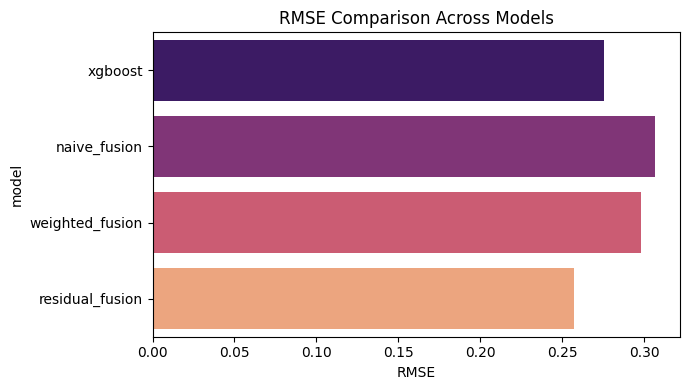

In [5]:
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.barplot(
    data=results_df,
    x="rmse",
    y="model",
    hue="model",
    palette="magma",
    legend=False
)
plt.xlabel("RMSE")
plt.title("RMSE Comparison Across Models")
plt.tight_layout()
plt.show()


**Observation:**  
Naive multimodal fusion degrades performance, while residual fusion achieves the
lowest RMSE, outperforming the strong XGBoost baseline.


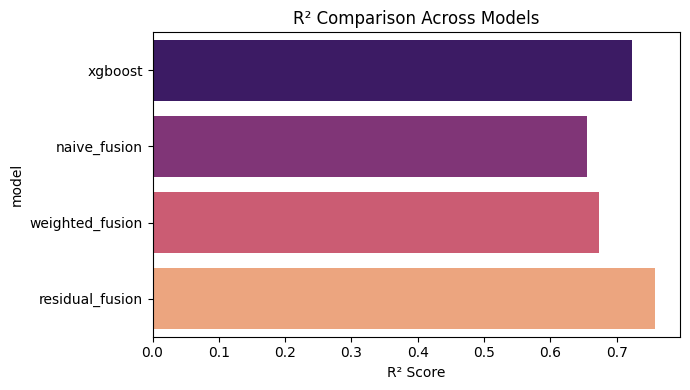

In [6]:
plt.figure(figsize=(7, 4))
sns.barplot(
    data=results_df,
    x="r2",
    y="model",
    hue="model",
    palette="magma",
    legend=False
)
plt.xlabel("R² Score")
plt.title("R² Comparison Across Models")
plt.tight_layout()
plt.show()

**Observation:**  
Residual fusion explains the largest fraction of variance in property prices,
demonstrating that satellite imagery provides complementary predictive signal.


In [12]:
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"

val_df = pd.read_csv(PROCESSED_DIR / "val_processed.csv")
y_true = val_df["log_price"].values
val_with_xgb = pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv")
xgb_preds = val_with_xgb["xgb_pred"].values


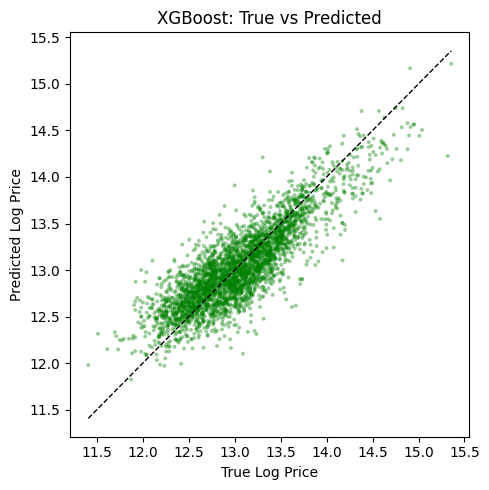

In [15]:
plt.figure(figsize=(5, 5))

plt.scatter(
    y_true,
    xgb_preds,
    s=8,
    alpha=0.4,
    color="green",
    edgecolors="none"
)

min_val = min(y_true.min(), xgb_preds.min())
max_val = max(y_true.max(), xgb_preds.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle="--",
    color="black",
    linewidth=1
)

plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("XGBoost: True vs Predicted")

plt.tight_layout()
plt.show()


**Observation:**
XGBoost captures most of the global structure but exhibits systematic residual errors.


In [18]:
import sys
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [19]:
from src.dataset import PropertyDataset
from src.models import CNNResidualRegressor
import torch

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_residual = CNNResidualRegressor().to(DEVICE)
model_residual.load_state_dict(
    torch.load(
        OUTPUT_DIR / "adaptive_fusion_final.pth",
        map_location=DEVICE,
        weights_only=True
    )
)

model_residual.eval()

val_res_ds = PropertyDataset(
    PROCESSED_DIR / "val_with_xgb.csv",
    DATA_DIR / "images",
    split="train",
    mode="residual",
    zooms=("zoom16",),
    xgb_pred_col="xgb_pred"
)

from torch.utils.data import DataLoader
val_res_loader = DataLoader(val_res_ds, batch_size=32, shuffle=False)

cnn_residuals = []
with torch.no_grad():
    for imgs, _ in val_res_loader:
        cnn_residuals.append(model_residual(imgs.to(DEVICE)).cpu().numpy())

cnn_residuals = np.concatenate(cnn_residuals)
final_preds = xgb_preds + cnn_residuals

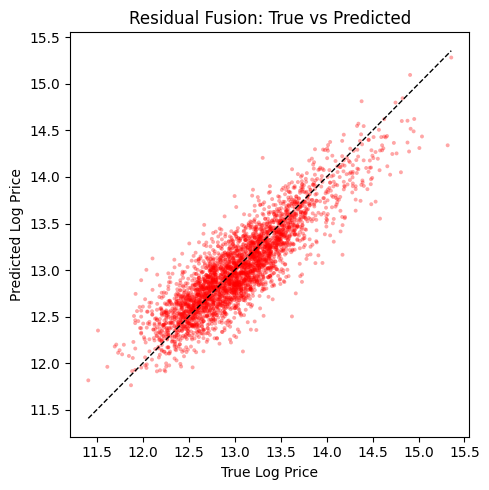

In [24]:
plt.figure(figsize=(5, 5))

plt.scatter(
    y_true,
    final_preds,
    s=8,
    alpha=0.35,
    color="red",
    edgecolors="none"
)

min_val = min(y_true.min(), final_preds.min())
max_val = max(y_true.max(), final_preds.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle="--",
    color="black",
    linewidth=1
)

plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Residual Fusion: True vs Predicted")

plt.tight_layout()
plt.show()


Residual fusion tightens predictions around the diagonal,
reducing systematic errors present in the tabular-only model.


In [25]:
xgb_residuals = y_true - xgb_preds
final_residuals = y_true - final_preds


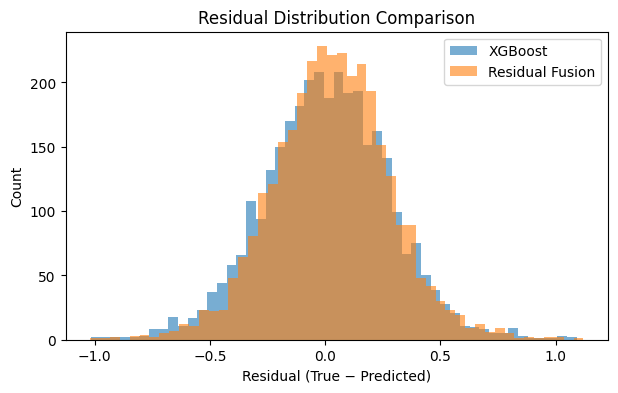

In [29]:
plt.figure(figsize=(7, 4))
plt.hist(xgb_residuals, bins=50, alpha=0.6, label="XGBoost")
plt.hist(final_residuals, bins=50, alpha=0.6, label="Residual Fusion")
plt.xlabel("Residual (True − Predicted)")
plt.ylabel("Count")
plt.legend()
plt.title("Residual Distribution Comparison")
plt.show()


Residual fusion reduces both the spread and bias of prediction errors,
indicating improved generalization.


## Results Summary

- Naive multimodal fusion degrades performance due to modality interference.
- Weighted fusion stabilizes training but remains inferior to the tabular baseline.
- Residual fusion achieves the best performance:
  - Lowest RMSE
  - Highest R²
- Satellite imagery provides complementary spatial information when integrated
  through a residual learning framework.

These results confirm that careful fusion design is critical for effective
multimodal learning.
